In [1]:
### RUN THIS ONLY IF YOU HAVE MISSING PACKAGES
# import sys
# !{sys.executable} -m pip install Nasdaq-Data-Link

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import nasdaqdatalink
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

## Obtain required pairs

In this exercise, we restrict our trading universe to the HSCI universe.

In [3]:
# Import information on HSCI
hkex_tickrs = pd.read_csv('hsci_universe.csv')
hkex_tickrs = hkex_tickrs.dropna() # remove redundant rows

# Format tickers to the required form for API
hkex_tickrs['Stock Code'] = hkex_tickrs['Ticker'].apply(lambda x: '{0:0=5d}'.format(int(x.split()[0])))
hkex_tickrs.head()

,Ticker,Name,GICS SubInd Name\n,GICS Ind Name\n,GICS Sector\n,Stock Code
0,1972 HK Equity,Swire Properties Ltd,Real Estate Operating Companies,Real Estate Management & Development,Real Estate,01972
1,857 HK Equity,PetroChina Co Ltd,Integrated Oil & Gas,"Oil, Gas & Consumable Fuels",Energy,00857
2,1898 HK Equity,China Coal Energy Co Ltd,Coal & Consumable Fuels,"Oil, Gas & Consumable Fuels",Energy,01898
3,1882 HK Equity,Haitian International Holdings Ltd,Industrial Machinery & Supplies & Components,Machinery,Industrials,01882
4,3339 HK Equity,Lonking Holdings Ltd,Construction Machinery & Heavy Transportation ...,Machinery,Industrials,03339


In [4]:
DTW_pairs = pd.read_csv('V2_dtw_matrix-HK100_post_cluster.csv', index_col=0)
for col in ['Ticker_1', 'Ticker_2']:
    DTW_pairs[col] = DTW_pairs[col].apply(lambda x: '{0:0=5d}'.format(x))
    
DTW_pairs.head()

,Ticker_1,Ticker_2,DTW_Distance
0,01288,03988,335.33
1,00998,01398,453.44
2,00939,01398,923.47
3,00939,00998,1024.79
4,00902,00916,1077.47


In [5]:
checks = ['GICS SubInd Name\n', 'GICS Ind Name\n', 'GICS Sector\n']

for check in checks:
    DTW_pairs[check] = DTW_pairs.apply(lambda x: 1 if hkex_tickrs.loc[hkex_tickrs['Stock Code'] == x['Ticker_1'],check].values
                                      == hkex_tickrs.loc[hkex_tickrs['Stock Code'] == x['Ticker_2'],check].values else 0,
                                      axis = 1)


In [6]:
DTW_pairs['score'] = DTW_pairs[checks].sum(axis = 1)
DTW_pairs = DTW_pairs.sort_values(by = ['score', 'DTW_Distance'], ascending = [False, True])

In [7]:
DTW_pairs

,Ticker_1,Ticker_2,DTW_Distance,GICS SubInd Name\n,GICS Ind Name\n,GICS Sector\n,score
0,01288,03988,335.330000,1,1,1,3
1,00998,01398,453.440000,1,1,1,3
2,00939,01398,923.470000,1,1,1,3
3,00939,00998,1024.790000,1,1,1,3
7,00386,00857,1291.750000,1,1,1,3
...,...,...,...,...,...,...,...
570,00700,00883,206039.090016,0,0,0,0
573,00700,00992,209627.860016,0,0,0,0
574,00700,00857,210092.260016,0,0,0,0
575,00386,00700,210777.430016,0,0,0,0


## Get required price data

In [8]:
qualified_tickers = pd.unique(DTW_pairs[['Ticker_1', 'Ticker_2']].values.ravel('K'))
qualified_tickers

array(['01288', '00998', '00939', '00386', '01398', '02007', '00902',
       '00960', '00728', '00027', '01109', '01299', '02020', '03968',
       '00123', '01211', '02318', '00005', '00016', '00916', '00981',
       '00857', '00883', '02601', '02328', '00525', '00175', '02388',
       '00881', '02628', '00291', '01928', '01093', '00669', '02313',
       '02382', '00836', '00762', '00700', '00388', '02899', '01919',
       '01171', '00241', '00868', '02331', '01177', '00688', '01088',
       '02380', '00914', '00992', '02319', '00316', '01099', '00168',
       '02333', '01038', '03800', '00001', '00020', '00941', '02688',
       '00006', '03988', '03900', '06030', '03888'], dtype=object)

In [9]:
myapikey = 'xKi8BYdvaTAzK4V_fxM2'

# RUN THIS CELL ONLY IF YOU DO NOT HAVE THE DATA REQUIRED ALREADY

sdate = '2018-05-22' # specify start date
edate = '2023-05-22' # specify end date

stock_data = pd.DataFrame()
cols = ['Ticker', 'Nominal Price', 'Bid', 'Ask', 'High', 'Low', 'Share Volume (000)', 'Turnover (000)']

for ticker in qualified_tickers:
    # Do a GET request
    df = nasdaqdatalink.get(f'HKEX/{ticker}', start_date = sdate, end_date = edate, api_key = myapikey)
    df['Ticker'] = ticker
    df = df.loc[:, cols]

    if stock_data.empty:
        stock_data = df.copy()
    else:
        stock_data = pd.concat([stock_data, df])

In [10]:
# Convert the extracted data into closing prices only
stock_prices = pd.crosstab(stock_data.index, stock_data.Ticker, values = stock_data['Nominal Price'], aggfunc = np.sum)
stock_prices = stock_prices.fillna(method = 'ffill')
stock_prices.describe()

Ticker,00001,00005,00006,00016,00020,00027,00123,00168,00175,00241,...,02601,02628,02688,02899,03800,03888,03900,03968,03988,06030
count,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,...,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000
mean,62.122868,52.427132,49.062998,108.590861,41.116361,52.321080,4.238091,59.491633,16.490812,10.979773,...,25.442112,16.137124,101.830301,7.003769,1.379907,28.955768,10.005938,44.539886,3.041389,16.752283
std,13.416840,11.148923,5.583560,12.433528,23.860815,7.761635,3.468185,15.725562,5.237689,6.567741,...,5.452301,3.256619,25.046420,3.790591,1.041283,12.542040,2.824958,12.212233,0.350499,2.091022
min,39.000000,28.200000,35.650000,84.200000,1.170000,34.550000,1.200000,29.800000,8.420000,3.040000,...,12.200000,8.550000,58.250000,2.360000,0.215000,10.140000,4.980000,25.800000,2.370000,11.740000
25%,51.750000,43.850000,43.825000,98.150000,6.600000,46.525000,1.530000,47.025000,12.430000,6.385000,...,21.750000,13.410000,81.000000,3.120000,0.410000,19.160000,7.820000,36.325000,2.755000,15.050000
50%,57.050000,51.200000,49.450000,108.300000,52.250000,51.900000,1.780000,62.800000,15.160000,7.770000,...,25.050000,16.320000,96.000000,7.200000,0.830000,26.100000,10.060000,39.700000,2.990000,16.780000
75%,74.275000,60.750000,54.250000,117.050000,61.300000,57.200000,7.620000,73.500000,19.780000,15.690000,...,29.600000,18.660000,120.800000,10.560000,2.190000,35.800000,11.880000,56.500000,3.250000,18.240000
max,92.050000,77.550000,58.500000,141.600000,66.000000,78.250000,13.280000,89.500000,33.800000,29.900000,...,41.450000,23.050000,177.000000,14.580000,3.920000,78.100000,18.140000,71.750000,4.250000,21.900000


In [11]:
split = int(stock_prices.shape[0] * 0.8)
stock_prices_train = stock_prices.iloc[:split,:].copy()
stock_prices_test = stock_prices.iloc[split-100:,:].copy()

In [34]:
class pairs_trading:
    """
    Pairs trading strategy class.
    
    Parameters:
    - data (DataFrame): Input data containing the pair of stocks.
    - pair (tuple): Pair of stocks to trade.
    - trade_bound (float): Threshold for entering a trade (default: 1.6).
    - exit_bound (float): Threshold for exiting a trade (default: 1.0).
    - mode (str): Mode for trading signals calculation (default: 'z').
    - window (int): Window size for calculating moving averages (default: 60).
    - start (int): Starting index for trading (default: 100).
    - cost (bool): Flag indicating whether to include trading cost (default: False).
    """
    def __init__(self, data, pair, trade_bound = 1.6, exit_bound = 1.0, stop_bound = 2.0,\
                 mode = 'z', window = 60, start = 100, cost = False):
        self.ID = '{0} - {1}'.format(pair[0], pair[1])
        self.leg1 = pair[0]
        self.leg2 = pair[1]
        self.cost = cost
        self.series1 = data[pair[0]].copy()
        self.series2 = data[pair[1]].copy()
        self.len = self.series1.shape[0]
        self.mode = mode
        self.window = window
        self.start = start
        
        self.slope, self.intercept = self.__regression__() 
        
        
        self.trade_bound = trade_bound
        self.stop_bound = stop_bound
        if isinstance(exit_bound, tuple):
            self.long_exit_bound = exit_bound[0]
            self.short_exit_bound = exit_bound[1]
        else:
            self.long_exit_bound = -exit_bound
            self.short_exit_bound = exit_bound
        
        self.spread = self.__get_spread__()
        if mode == 'z':
            self.spread_ma60, self.zscore = self.__features_engineering__()
            self.sscore = None
            
        elif mode == 's':
            self.sscore = self.__OU_process__()
            self.spread_ma60 = None
            self.zscore = None
            
        else:
            print('Warning: invalid mode selected. Setting mode to z-score')
            self.spread_ma60, self.zscore = self.__features_engineering__()
            self.sscore = None
            
        self.tradelog = self.trading()
        
    def __regression__(self):
        """
        Perform linear regression between the two stock series.

        Returns:
        - tuple: Slope and intercept of the regression line.
        """
        p0 = self.series1
        p1 = sm.add_constant(self.series2)
        intercept, slope = sm.OLS(p0, p1).fit().params

        return slope,intercept
    
    def __get_spread__(self): 
        """
        Calculate the spread based on linear regression.

        Returns:
        - Series: Spread between the two stock series.
        """
        
        return (self.series1 - self.series2 * self.slope) - self.intercept
    
    def __features_engineering__(self): 
        """
        Create features for trading signals.

        Returns:
        - tuple: Spread moving average (spread_ma60) and z-score (zscore).
        """
        
        # Take 60D-moving average spread as the LT mean-reversion average
        spread_ma60 = self.spread.rolling(window=self.window,
                                       center=False).mean()
        
        # Find standard deviation of the 60D
        std_60 = self.spread.rolling(window=self.window,
                                center=False).std()
        
        # Calculate Z-score
        zscore = (self.spread - spread_ma60)/std_60

        return spread_ma60, zscore
    
    def __coint_test__(self, t):
        """
        Perform cointegration test on a subset of the series.

        Parameters:
        - t (int): Current index.

        Returns:
        - float: p-value of the cointegration test.
        """
        score, pvalue, _ = coint(self.series1.iloc[t-100:t],self.series2.iloc[t-100:t])
        return pvalue
    
    def trading(self):
        """
        Perform pairs trading based on the calculated signals.

        Returns:
        - DataFrame: Trading log containing the positions and P&L.
        """
        series1_ret = self.series1.pct_change()
        series2_ret = self.series2.pct_change()
        
        df = pd.DataFrame()
        
        df['spread'] = self.spread
        df['position'] = 0
        df['cost'] = 0
        df = df.fillna(0)
        df['score'] = self.zscore if self.mode == 'z' else self.sscore
        df['p_values'] = None
        
        T = df.shape[0]
        p_value = None
        
                
        for t in range(self.start, T):
            if (t - self.start) % 20 == 0:
                p_value = self.__coint_test__(t)
            
            if p_value < 0.05:
                if abs(df['score'].iloc[t]) > self.trade_bound and df['position'].iloc[t-1] == 0:
                    df['position'].iloc[t] = -1 * np.sign(df['score'].iloc[t])
                    df['cost'].iloc[t] = 0.003 if self.cost else 0
                    
                    
                elif self.long_exit_bound < df['score'].iloc[t] < self.short_exit_bound:
                    # Exit signal
                    df['position'].iloc[t] = 0
                    df['cost'].iloc[t] = 0.003 if self.cost else 0
                
                elif abs(df['score'].iloc[t]) > self.stop_bound:
                    # stop-loss
                    df['position'].iloc[t] = 0
                    df['cost'].iloc[t] = 0.003 if self.cost else 0
                    
                else:
                    df['position'].iloc[t] = df['position'].iloc[t-1]
                    
            else:
                df['position'].iloc[t] = 0
                
            
            df['p_values'].iloc[t] = p_value
            
        # position
        df['leg1'] = df['position']
        df['leg2'] = df['position'] * self.slope * -1
        df['dailypnl'] = df['leg2'] * series2_ret.shift(-1) + df['leg1'] * series1_ret.shift(-1) - df['cost']
        df['cumpnl'] = df['dailypnl'].cumsum()
        

        return df.iloc[100:,:]
    
    def performance(self, to_print = True):
        """
        Calculate and display performance statistics.

        Parameters:
        - to_print (bool): Flag indicating whether to print the statistics (default: True).

        Returns:
        - tuple: Sharpe ratio, maximum drawdown, total returns.
        """
        pnl = self.tradelog['dailypnl']
        cumpnl = self.tradelog['cumpnl']
        if np.std(pnl) > 0:
            sharpe = pnl.mean()/np.std(pnl)
            sharpe = sharpe*np.sqrt(252)
        else:
            sharpe = np.nan
            
        highwatermark_df = cumpnl.cummax();
        drawdown_df = cumpnl - highwatermark_df;
        maxdrawdown = drawdown_df.min();
        
            
        if to_print == True:
            print("")
            print ("PERFORMANCE STATISTICS FOR {}-{}".format(self.leg1, self.leg2));
            print("Daily annualized sharpe: "+str(sharpe))
            print ("Average annual returns: "+str(pnl.mean()*252*100)+"%")
            print ("Total returns: "+str(pnl.sum()*100)+"%");
            print ("Max drawdown: "+str(maxdrawdown*100)+"%");
        
        return sharpe, maxdrawdown, pnl.sum()
    
    def __OU_process__(self):
        ret_series1 = self.series1.pct_change().dropna()
        ret_series2 = self.series2.pct_change().dropna()
        
        s_scores = []
        
        for i in range(self.window, self.len-1):
            # Model linear regression on the return series of the pair
            Y1 = ret_series1.iloc[i - self.window : i]
            X1 = ret_series2.iloc[i - self.window : i]
            epsilon, beta = sm.OLS(Y1, sm.add_constant(X1)).fit().params
            spread = Y1 - (beta*X1 + epsilon)
            
            # Cumulative Spread
            Xk = np.array(spread.cumsum())
            X2 = Xk[:-1].reshape(-1,1)
            Y2 = Xk[1:]

            a, b = sm.OLS(Y2, sm.add_constant(X2)).fit().params
            
            zeta = Y2 - (b*X2 + a)

            # get OU parameters
            kappa = -np.log(b) * 252
            m = a / (1-b)
            sigma = np.sqrt(np.var(zeta)*2*kappa/(1 - np.square(b)))
            sigma_eq = np.sqrt(np.var(zeta)/(1 - np.square(b)))
            
            if kappa > 252/30:
                m = a / (1-b)
                s = -m/sigma_eq
                s_scores.append(s)
            else:
                s_scores.append(np.nan)
        
        return pd.Series(s_scores, index=self.series1.index[self.window+1:])
           
              
    
    
    def plot_data(self): 
        """
        Plot the pair prices, spreads, z-score, p-values, and P&L.
        """
        f, ax = plt.subplots(5,1,figsize=(15,25),sharex = True)
        # plot prices
        ax[0].title.set_text('Stocks\' Prices')
        self.series1.iloc[self.start:].plot(ax=ax[0], label = self.leg1)
        self.series2.iloc[self.start:].plot(ax=ax[0], label = self.leg2)
        ax[0].set(ylabel = 'Price')
        ax[0].legend()
        
        
        # plot spread and technical indicators
        ax[1].title.set_text('Spread')
        ax[1].plot(self.spread.index[self.start:], self.spread.values[self.start:])
        ax[1].plot(self.spread_ma60.index[self.start:], self.spread_ma60.values[self.start:])
        ax[1].legend(['Spread','Spread 60days MA'])
        ax[1].set(ylabel = 'Spread')
        
        # plot score
        ax[2].title.set_text('Z-Score')
        self.zscore.plot(ax=ax[2])
        ax[2].set(ylabel = 'Z-score')
 
        ax[2].axhline(self.trade_bound, color='b')
        ax[2].axhline(-self.trade_bound, color='b')
        ax[2].axhline(self.long_exit_bound, color='g', ls = '--')
        ax[2].axhline(self.short_exit_bound, color='g', ls = '--')
        ax[2].axhline(0, color='k')
        
        # plot p-values
        ax[3].title.set_text('p-values')
        ax[3].plot(self.tradelog['p_values'].index, self.tradelog['p_values'].values)
        ax[3].set(ylabel = 'p-values')
        
        # plot pnl
        ax[4].title.set_text('PNL')
        ax[4].plot(self.tradelog['cumpnl'].index, self.tradelog['cumpnl'].values)
        ax[4].set(ylabel = 'PNL')
        
        return None

In [13]:
class portfolio:
    def __init__(self, data, valid_pairs, **kw):
        """
        Initializes a portfolio of pairs trading strategies.
        Parameters:
        - data (DataFrame): Data containing the price series of the stocks.
        - valid_pairs (list): List of valid pairs to be traded.
        - **kw: Additional keyword arguments to be passed to the pairs_trading strategy.

        """
        self.trade_objects = {}
        performances = []
        self.pnl = pd.DataFrame()
        for pair in valid_pairs:
            trade = pairs_trading(data, pair, **kw)
            self.trade_objects[trade.ID] = trade
            
            performance = {'leg1': pair[0], 'leg2': pair[1]}
            performance['sharpe'], performance['MDD'], performance['cumpnl'] = trade.performance(to_print = False)
            performances.append(performance)           
            
            self.pnl[trade.ID] = trade.tradelog['dailypnl'].values
        
        self.indiv_performances = pd.DataFrame(performances)
        
        self.pnl['aggregate'] = self.pnl.sum(axis = 1)
        
    def performance(self, to_print = True):
        """
        Calculate and display performance statistics for the portfolio.

        Parameters:
        - to_print (bool): Flag indicating whether to print the statistics (default: True).

        Returns:
        - tuple: Sharpe ratio, maximum drawdown, total returns.
        """
        pnl = self.pnl['aggregate']
        cumpnl = pnl.cumsum()

        if np.std(pnl) > 0:
            sharpe = pnl.mean()/np.std(pnl)
            sharpe = sharpe*np.sqrt(252)
        else:
            sharpe = np.nan
            
        highwatermark_df = cumpnl.cummax();
        drawdown_df = cumpnl - highwatermark_df;
        maxdrawdown = drawdown_df.min();
        
            
        if to_print == True:
            print("")
            print ("PERFORMANCE STATISTICS FOR PORTFOLIO")
            print("Trading days:"+str(pnl.shape[0]))
            print("Daily annualized sharpe: "+str(sharpe))
            print ("Average annual returns: "+str(pnl.mean()*252*100)+"%")
            print ("Total returns: "+str(pnl.sum()*100)+"%");
            print ("Max drawdown: "+str(maxdrawdown*100)+"%");
        
        return sharpe, maxdrawdown, pnl.sum()
    
    def plot_performance(self):
        """
        Plot the daily P&L and cumulative P&L of the portfolio.
        """
        f, ax = plt.subplots(2,1,figsize=(10,5),sharex = True)
        ax[0].title.set_text('Daily PNL')
        ax[0].plot(self.pnl.index, self.pnl['aggregate'].values)
        
        ax[1].title.set_text('Cumulative PNL')
        ax[1].plot(self.pnl.index, self.pnl['aggregate'].cumsum().values)
        plt.show()

            

In [14]:
#selected_pairs = DTW_pairs.loc[(DTW_pairs.DTW_Distance < 30000) & (DTW_pairs.score > 1),:]
selected_pairs = DTW_pairs.loc[(DTW_pairs.score > 2),:]
selected_pairs

,Ticker_1,Ticker_2,DTW_Distance,GICS SubInd Name\n,GICS Ind Name\n,GICS Sector\n,score
0,01288,03988,335.33,1,1,1,3
1,00998,01398,453.44,1,1,1,3
2,00939,01398,923.47,1,1,1,3
3,00939,00998,1024.79,1,1,1,3
7,00386,00857,1291.75,1,1,1,3
11,00998,03988,1442.61,1,1,1,3
13,01398,03988,1543.93,1,1,1,3
15,00998,01288,1744.86,1,1,1,3
17,01288,01398,1846.18,1,1,1,3
30,00939,03988,2467.40,1,1,1,3


## Test trading strategy based on z-score

### Without Stop-loss

In [15]:
target_pairs = selected_pairs[['Ticker_1', 'Ticker_2']].values
hyperparams = {'trade_bound' : 1.4, 'exit_bound' : 1.0, 'stop_bound' : 100,'start':100}
train_portfolio = portfolio(stock_prices_train, target_pairs, **hyperparams)


PERFORMANCE STATISTICS FOR PORTFOLIO
Trading days:884
Daily annualized sharpe: 0.7947286994811176
Average annual returns: 307.2657423219267%
Total returns: 1077.8687151292984%
Max drawdown: -287.5915572820258%


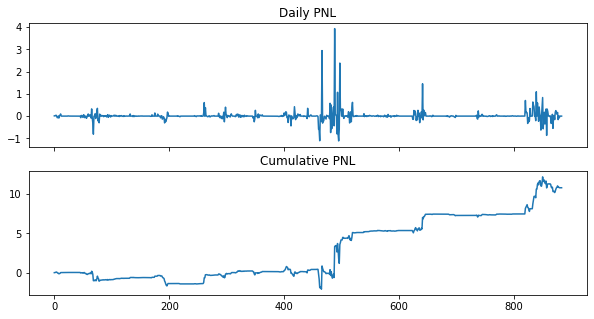

In [16]:
train_portfolio.performance()
train_portfolio.plot_performance()

In [17]:
final_pairs = train_portfolio.indiv_performances.loc[train_portfolio.indiv_performances['sharpe'] > 0,['leg1', 'leg2']].values


PERFORMANCE STATISTICS FOR PORTFOLIO
Trading days:247
Daily annualized sharpe: 1.2700436580023897
Average annual returns: 116.40831551214876%
Total returns: 114.09862671230454%
Max drawdown: -80.516082241705%


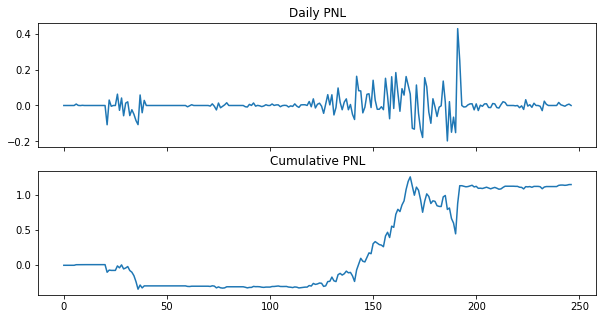

In [18]:
test_portfolio = portfolio(stock_prices_test, final_pairs, **hyperparams)
test_portfolio.performance()
test_portfolio.plot_performance()

### With Stop-loss

In [19]:
hyperparams = {'trade_bound' : 1.4, 'exit_bound' : 1.0, 'stop_bound' : 1.9,'start':100}
train_portfolio_sl = portfolio(stock_prices_train, target_pairs, **hyperparams)


PERFORMANCE STATISTICS FOR PORTFOLIO
Trading days:884
Daily annualized sharpe: 0.8910157854898237
Average annual returns: 268.8575689900574%
Total returns: 943.1352816952806%
Max drawdown: -200.34446328600964%


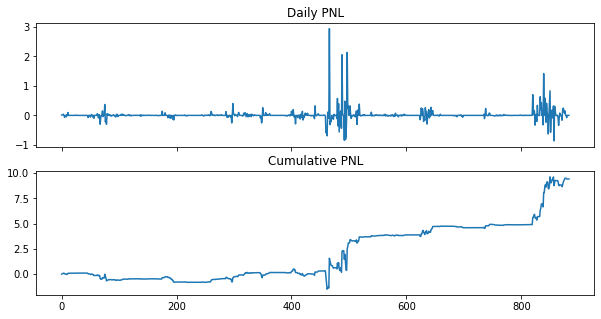

In [20]:
train_portfolio_sl .performance()
train_portfolio_sl .plot_performance()

In [21]:
final_pairs_sl = train_portfolio_sl.indiv_performances.loc[train_portfolio_sl.indiv_performances['sharpe'] > 0,['leg1', 'leg2']].values


PERFORMANCE STATISTICS FOR PORTFOLIO
Trading days:247
Daily annualized sharpe: 0.9951717529153895
Average annual returns: 72.13712300896333%
Total returns: 70.7058308857696%
Max drawdown: -74.66441584301113%


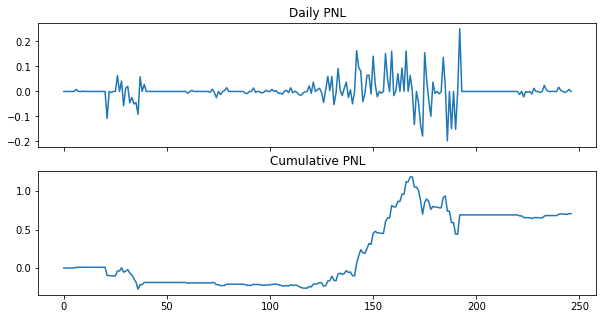

In [22]:
test_portfolio_sl = portfolio(stock_prices_test, final_pairs_sl, **hyperparams)
test_portfolio_sl.performance()
test_portfolio_sl.plot_performance()

### With stop-loss and transaction cost

In [35]:
hyperparams = {'trade_bound' : 1.4, 'exit_bound' : 1.0, 'stop_bound' : 1.9,'start':100, 'cost':True}
train_portfolio_txn = portfolio(stock_prices_train, target_pairs, **hyperparams)


PERFORMANCE STATISTICS FOR PORTFOLIO
Trading days:884
Daily annualized sharpe: 0.3343043910631698
Average annual returns: 100.72453731584943%
Total returns: 353.335281695281%
Max drawdown: -453.148916117706%


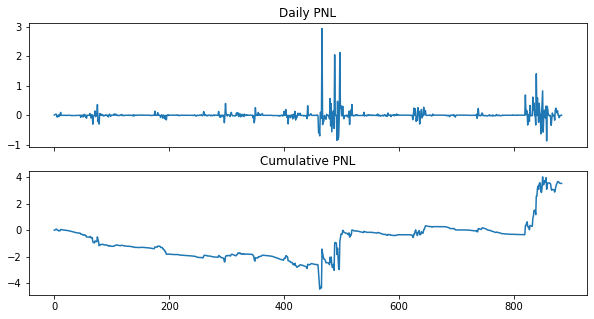

In [36]:
train_portfolio_txn .performance()
train_portfolio_txn .plot_performance()


PERFORMANCE STATISTICS FOR PORTFOLIO
Trading days:247
Daily annualized sharpe: 0.46463470743835467
Average annual returns: 32.89810970009021%
Total returns: 32.24536942826301%
Max drawdown: -76.95750394318756%


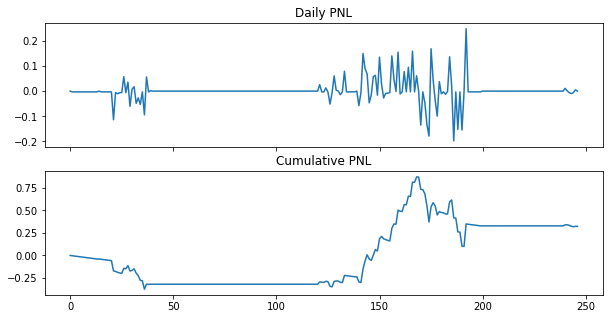

In [37]:
final_pairs_txn = train_portfolio_txn.indiv_performances.loc[train_portfolio_txn.indiv_performances['sharpe'] > 0,['leg1', 'leg2']].values

test_portfolio_txn = portfolio(stock_prices_test, final_pairs_txn, **hyperparams)
test_portfolio_txn.performance()
test_portfolio_txn.plot_performance()

---

## Test trading strategy based on s-score

### Without Stop-loss


PERFORMANCE STATISTICS FOR PORTFOLIO
Trading days:884
Daily annualized sharpe: 0.4651348335616768
Average annual returns: 64.80354660054081%
Total returns: 227.32672696380186%
Max drawdown: -137.71211928650376%


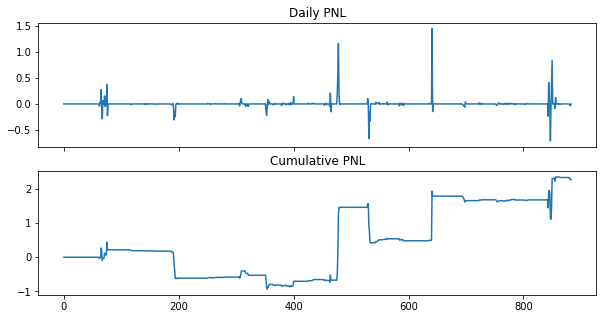

In [26]:
hyperparams = {'trade_bound' : 0.8, 'exit_bound' : (-0.40,0.60), 'stop_bound' : 100, 'start':100, 'mode':'s'}
train_portfolio_s = portfolio(stock_prices_train, target_pairs, **hyperparams)

train_portfolio_s.performance()
train_portfolio_s.plot_performance()

In [27]:
final_pairs_s = train_portfolio_s.indiv_performances.loc[train_portfolio.indiv_performances['sharpe'] > 0,['leg1', 'leg2']].values


PERFORMANCE STATISTICS FOR PORTFOLIO
Trading days:247
Daily annualized sharpe: 1.3210873328181705
Average annual returns: 23.991989546695244%
Total returns: 23.51595800807035%
Max drawdown: -7.220146896730542%


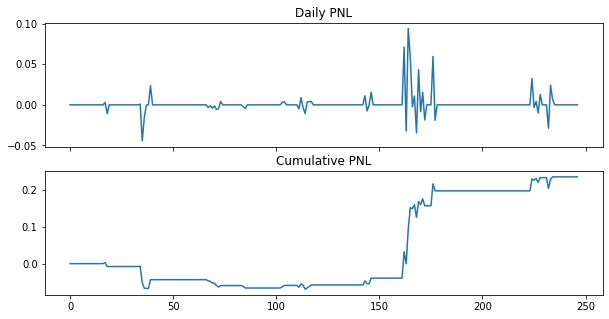

In [28]:
test_portfolio_s = portfolio(stock_prices_test, final_pairs_s, **hyperparams)
test_portfolio_s.performance()
test_portfolio_s.plot_performance()

### With Stop-Loss


PERFORMANCE STATISTICS FOR PORTFOLIO
Trading days:884
Daily annualized sharpe: 0.38139503687264537
Average annual returns: 49.23423244427693%
Total returns: 172.71056143151102%
Max drawdown: -137.71211928650376%


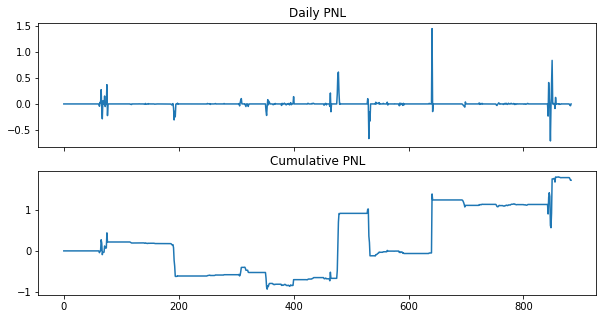

In [40]:
hyperparams = {'trade_bound' : 0.8, 'exit_bound' : (-0.40,0.60), 'stop_bound' : 1.6, 'start':100, 'mode':'s'}
train_portfolio_ssl = portfolio(stock_prices_train, target_pairs, **hyperparams)

train_portfolio_ssl.performance()
train_portfolio_ssl.plot_performance()

In [41]:
final_pairs_ssl = train_portfolio_ssl.indiv_performances.loc[train_portfolio_ssl.indiv_performances['sharpe'] > 0,['leg1', 'leg2']].values


PERFORMANCE STATISTICS FOR PORTFOLIO
Trading days:247
Daily annualized sharpe: 0.8717752057419755
Average annual returns: 38.052418485632764%
Total returns: 37.297410182346404%
Max drawdown: -12.599695277706715%


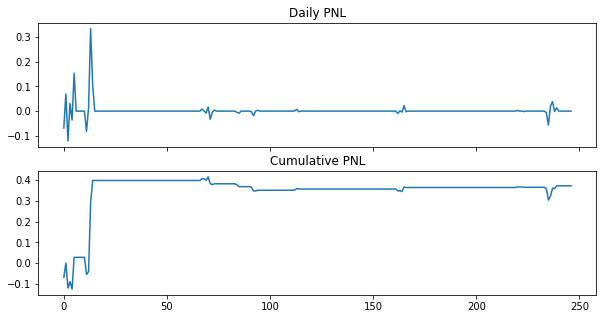

In [42]:
hyperparams = {'trade_bound' : 0.8, 'exit_bound' : (-0.40,0.60), 'stop_bound' : 1.6, 'start':100, 'mode':'s'}
test_portfolio_ssl = portfolio(stock_prices_test, final_pairs_ssl, **hyperparams)
test_portfolio_ssl.performance()
test_portfolio_ssl.plot_performance()

### With stop-loss and transaction cost


PERFORMANCE STATISTICS FOR PORTFOLIO
Trading days:884
Daily annualized sharpe: -0.9809597541789206
Average annual returns: -126.76667253309817%
Total returns: -444.68943856848904%
Max drawdown: -527.4359346342015%


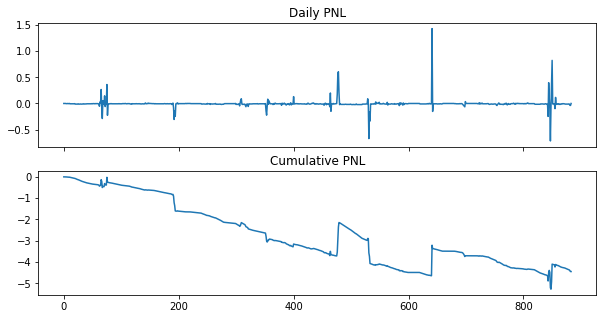

In [43]:
hyperparams = {'trade_bound' : 0.8, 'exit_bound' : (-0.40,0.60), 'stop_bound' : 1.6, 'start':100, 'mode':'s', 'cost':True}
train_portfolio_stxn = portfolio(stock_prices_train, target_pairs, **hyperparams)

train_portfolio_stxn.performance()
train_portfolio_stxn.plot_performance()


PERFORMANCE STATISTICS FOR PORTFOLIO
Trading days:247
Daily annualized sharpe: 0.5768959763308521
Average annual returns: 24.76211971263661%
Total returns: 24.27080781357636%
Max drawdown: -14.100000000000012%


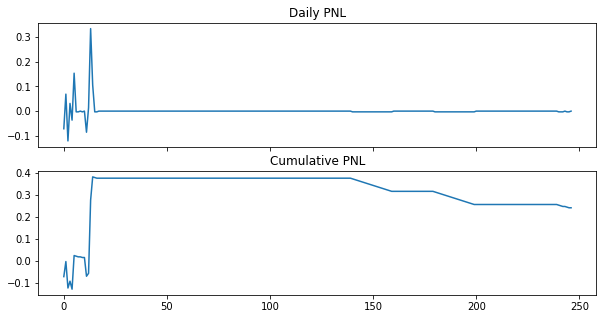

In [44]:
final_pairs_stxn = train_portfolio_stxn.indiv_performances.loc[train_portfolio_stxn.indiv_performances['sharpe'] > 0,['leg1', 'leg2']].values

test_portfolio_stxn = portfolio(stock_prices_test, final_pairs_stxn, **hyperparams)
test_portfolio_stxn.performance()
test_portfolio_stxn.plot_performance()